In [1]:
import argparse
import numpy as np
import sys
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
        Input,
        InputLayer,
        Flatten,
        Activation,
        Dense,
        Dropout)
from tensorflow.keras.layers import (
        Conv2D,
        MaxPooling2D)
from tensorflow.keras.activations import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import cv2

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
data = mnist.load_data(path='mnist.npz')

In [5]:
x_data = data[0][0][:,:,:,np.newaxis]
y_data = data[0][1]
x_test = data[1][0][:,:,:,np.newaxis]
y_test = data[1][1]

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.33, random_state=42, stratify=y_data)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40200, 28, 28, 1),
 (40200, 10),
 (19800, 28, 28, 1),
 (19800, 10),
 (10000, 28, 28, 1),
 (10000, 10))

In [7]:
y_list = np.unique(data[1][1])
y_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
input_shape = x_test[0].shape
output_size = y_list.shape[0]

In [9]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = 'vis_2D_CNN_custom_ch_32_DO_075_DO'

i = 3
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

#         del(model)


vis_2D_CNN_custom_ch_32_DO_075_DO_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        92

In [12]:
# image_path = 'husky.jpg'
layer_name = 'conv2d_18'
feature_to_visualize = 0
visualize_mode = 'max' ### max or all

In [13]:
layer_dict = {layer.name:layer for layer in model.layers}
if not layer_name in layer_dict:
    print('Wrong layer name')

In [14]:
layer_dict

{'activation_18': <tensorflow.python.keras.layers.core.Activation at 0x7f613c107e80>,
 'activation_19': <tensorflow.python.keras.layers.core.Activation at 0x7f613c107b38>,
 'activation_20': <tensorflow.python.keras.layers.core.Activation at 0x7f613c107860>,
 'conv2d_18': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f613c10e198>,
 'conv2d_19': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f613c107dd8>,
 'conv2d_20': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f613c107a58>,
 'dense_7': <tensorflow.python.keras.layers.core.Dense at 0x7f613c1076a0>,
 'dropout_7': <tensorflow.python.keras.layers.core.Dropout at 0x7f613c1076d8>,
 'flatten_7': <tensorflow.python.keras.layers.core.Flatten at 0x7f613c107780>,
 'input_8': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f613c10e470>,
 'max_pooling2d_18': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7f613c107ef0>,
 'max_pooling2d_19': <tensorflow.python.keras.layers.pooling.MaxPoo

In [34]:
img_array = x_test[0][np.newaxis,:]
img_array.shape

(1, 28, 28, 1)

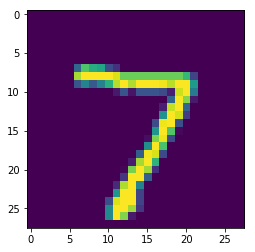

In [35]:
# y_list[np.argmax(model.predict(img_array))]
# img_array.shape
plt.figure()
plt.imshow(img_array.squeeze())

In [36]:
deconv_origin = visualize(model, img_array, 
                    layer_name, 0, visualize_mode)

In [109]:
deconv_origin = visualize(model, img_array, 'conv2d_19', 0, 'all')

(341, 341, 32)


In [41]:
deconv_origin.shape

(28, 28)

In [43]:
deconv = deconv_origin - deconv_origin.min()
deconv *= 1.0 / (deconv.max() + 1e-8)
deconv = deconv[:, :, ::-1]
uint8_deconv = (deconv * 255).astype(np.uint8)
plt.figure()
plt.imshow(uint8_deconv)

IndexError: too many indices for array

In [ ]:
img = Image.fromarray(uint8_deconv, 'RGB')
img.save('results/{}_{}_{}.png'.format(layer_name, feature_to_visualize, visualize_mode))

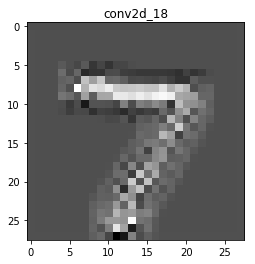

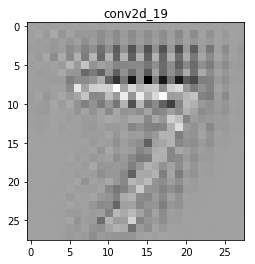

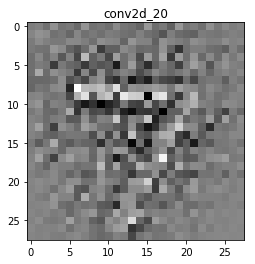

In [52]:
output_base = 'from_professor/visualization/2D/vis_2D_CNN_custom_ch_32_DO_075_DO/Deconvnet/'
os.makedirs(output_base, exist_ok=True)

layer_idx = 0

conv_list = [layer for layer in model.layers if isinstance(layer, Conv2D)]
output_layer = [layer for layer in model.layers if isinstance(layer, Dense)][-1]

for layer in conv_list:
    deconv_origin = visualize(model, img_array, 
                              layer.name, layer_idx, 'all')
    deconv = deconv_origin - deconv_origin.min()
    deconv *= 1.0 / (deconv.max() + 1e-8)
#     deconv = deconv[:, :, ::-1]
    uint8_deconv = (deconv * 255).astype(np.uint8)
    plt.figure()
    plt.title(layer.name)
    plt.imsave(os.path.join(output_base, 
                            'all_{}_layer_{}_filter'.format(layer.name, layer_idx)), uint8_deconv)
    plt.imshow(uint8_deconv, cmap='gray')
    
# deconv_origin = visualize(model, img_array, 
#                           output_layer.name, 7, 'all')
# deconv = deconv_origin - deconv_origin.min()
# deconv *= 1.0 / (deconv.max() + 1e-8)
# # deconv = deconv[:, :, ::-1]
# # uint8_deconv = (deconv * 255).astype(np.float32)
# plt.figure()
# plt.title(output_layer.name)
# plt.imsave(os.path.join(output_base, 
#                         'all_{}_layer_{}_dog'.format(output_layer.name, 7)), uint8_deconv)
# plt.imshow(uint8_deconv, cmap='gray')

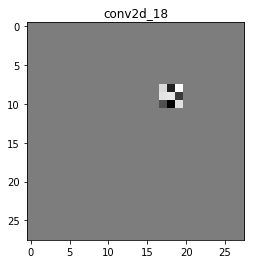

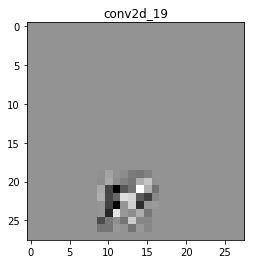

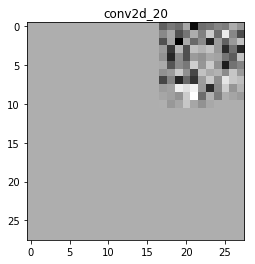

In [53]:
output_base = 'from_professor/visualization/2D/vis_2D_CNN_custom_ch_32_DO_075_DO/Deconvnet/'
os.makedirs(output_base, exist_ok=True)

layer_idx = 0

conv_list = [layer for layer in model.layers if isinstance(layer, Conv2D)]
output_layer = [layer for layer in model.layers if isinstance(layer, Dense)][-1]

for layer in conv_list:
    deconv_origin = visualize(model, img_array, 
                              layer.name, layer_idx, 'max')
    deconv = deconv_origin - deconv_origin.min()
    deconv *= 1.0 / (deconv.max() + 1e-8)
#     deconv = deconv[:, :, ::-1]
    uint8_deconv = (deconv * 255).astype(np.uint8)
    plt.figure()
    plt.title(layer.name)
    plt.imsave(os.path.join(output_base, 
                            'max_{}_layer_{}_filter'.format(layer.name, layer_idx)), uint8_deconv)
    plt.imshow(uint8_deconv, cmap='gray')
    
# deconv_origin = visualize(model, img_array, 
#                           output_layer.name, 7, 'max')
# deconv = deconv_origin - deconv_origin.min()
# deconv *= 1.0 / (deconv.max() + 1e-8)
# # deconv = deconv[:, :, ::-1]
# # uint8_deconv = (deconv * 255).astype(np.uint8)
# plt.figure()
# plt.title(output_layer.name)
# plt.imsave(os.path.join(output_base, 
#                         'max_{}_layer_{}_dog'.format(output_layer.name, 7)), uint8_deconv)
# plt.imshow(uint8_deconv, cmap='gray')

In [69]:
plt.yticks([])

--- Layer 1 ---


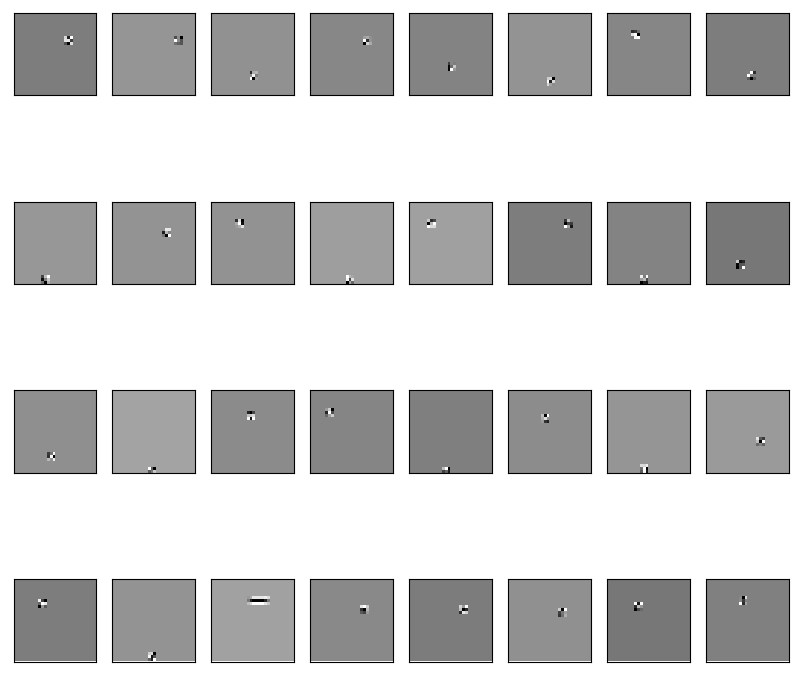

--- Layer 2 ---


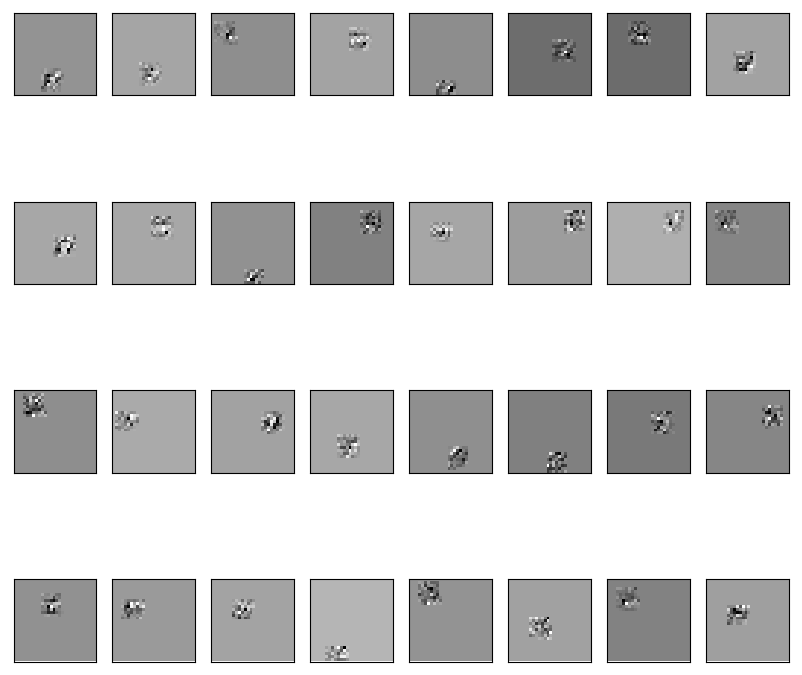

--- Layer 3 ---


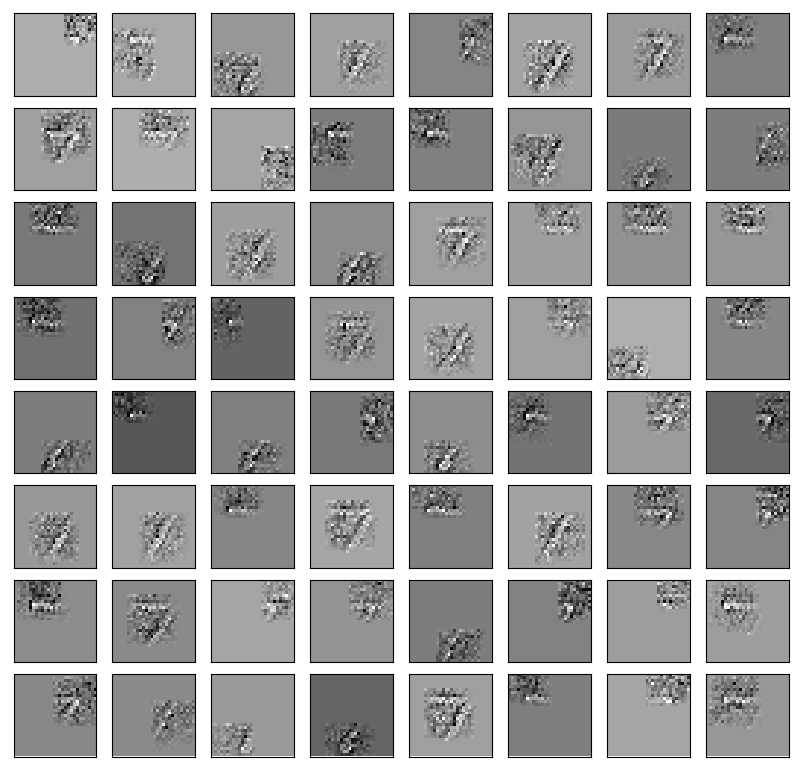

In [75]:
# y_min = -1
# y_max = 1

output_base = 'from_professor/visualization/2D/vis_2D_CNN_custom_ch_32_DO_075_DO/Deconvnet/'
os.makedirs(output_base, exist_ok=True)

conv_list = [layer for layer in model.layers if isinstance(layer, Conv2D)]

for layer_index, layer in enumerate(conv_list):
    num_of_filter = layer.filters
    plot_per_row = 8
    num_of_row = np.around(num_of_filter/plot_per_row)
    fig = plt.figure(figsize=(10, 10*((layer_index//8)+1)), dpi=100)
    plt.subplots_adjust(wspace=0.2, hspace=0)
    
    for filter_index in range(num_of_filter):
        plt.subplot(num_of_row, plot_per_row, filter_index+1)
        deconv_origin = visualize(model, img_array, 
                                  layer.name, filter_index, 'max')
        deconv = deconv_origin - deconv_origin.min()
        deconv *= 1.0 / (deconv.max() + 1e-8)
    #     deconv = deconv[:, :, ::-1]
        uint8_deconv = (deconv * 255).astype(np.uint8)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(uint8_deconv, cmap='gray')
    print('--- Layer {} ---'.format(layer_index+1))
    save_name = 'vis_2D_CNN_custom_ch_32_DO_075_DO_{}_layer'.format(layer_index+1) 
    plt.savefig(output_base+save_name)
    plt.show()


--- Layer 1 ---


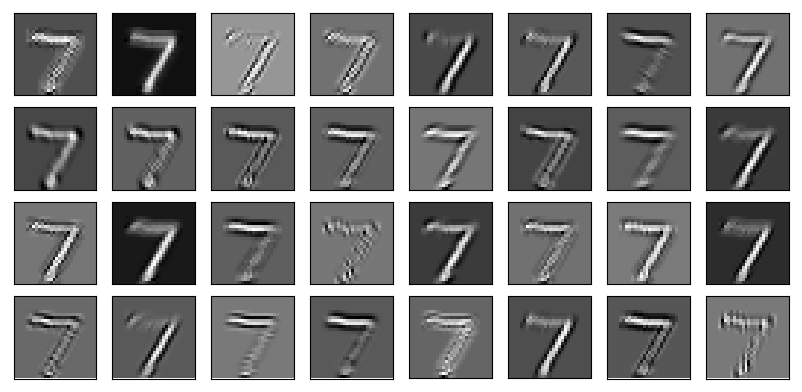

--- Layer 2 ---


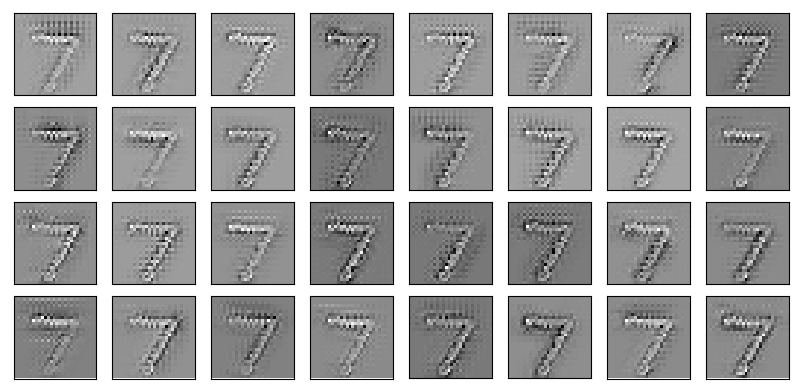

--- Layer 3 ---


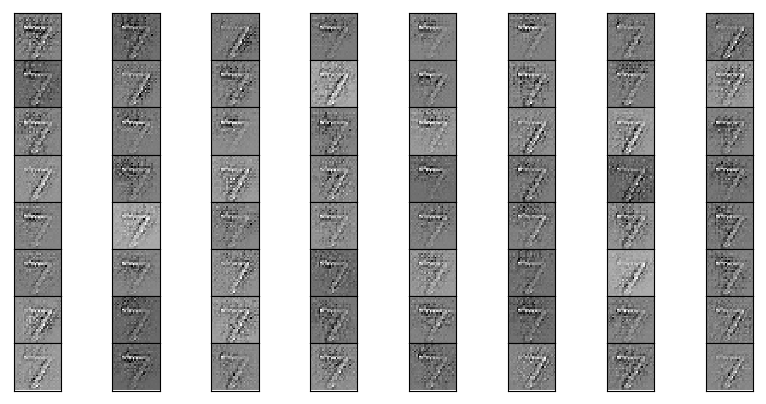

In [78]:
# y_min = -1
# y_max = 1

output_base = 'from_professor/visualization/2D/vis_2D_CNN_custom_ch_32_DO_075_DO/Deconvnet/'
os.makedirs(output_base, exist_ok=True)

conv_list = [layer for layer in model.layers if isinstance(layer, Conv2D)]

for layer_index, layer in enumerate(conv_list):
    num_of_filter = layer.filters
    plot_per_row = 8
    num_of_row = np.around(num_of_filter/plot_per_row)
    fig = plt.figure(figsize=(10, 5*((layer_index//8)+1)), dpi=100)
    plt.subplots_adjust(wspace=0.2, hspace=0)
    
    for filter_index in range(num_of_filter):
        plt.subplot(num_of_row, plot_per_row, filter_index+1)
        deconv_origin = visualize(model, img_array, 
                                  layer.name, filter_index, 'all')
        deconv = deconv_origin - deconv_origin.min()
        deconv *= 1.0 / (deconv.max() + 1e-8)
    #     deconv = deconv[:, :, ::-1]
        uint8_deconv = (deconv * 255).astype(np.uint8)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(uint8_deconv, cmap='gray')
    print('--- Layer {} ---'.format(layer_index+1))
    save_name = 'all_vis_2D_CNN_custom_ch_32_DO_075_DO_{}_layer'.format(layer_index+1) 
    plt.savefig(output_base+save_name)
    plt.show()


In [26]:
class DConv2D(object):
    '''
    A class to define forward and backward operation on Conv2D
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Conv2D layer, whose configuration 
                   will be used to initiate DConv2D(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer

        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]

        # Set up_func for DConv2D
        nb_up_filter = W.shape[3]
        nb_up_row = W.shape[1]
        nb_up_col = W.shape[0]
        input_ = Input(shape = layer.input_shape[1:])
        output_conv = Conv2D(
                    filters = nb_up_filter, 
                    kernel_size = (nb_up_row, nb_up_col), 
                    strides=(1, 1), 
                    padding='same'
        )
        output = output_conv(input_)
        output_conv.set_weights([W,b])
        
        self.up_func = K.function([input_, K.learning_phase()], output)

        # Flip W horizontally and vertically, 
        # and set down_func for DConvolution2D
        W = np.transpose(W, (0, 1, 3, 2))
        W = W[::-1, ::-1, :, :]
        nb_down_filter = W.shape[3]
        nb_down_row = W.shape[1]
        nb_down_col = W.shape[0]
        b = np.zeros(nb_down_filter)
        input_ = Input(shape = layer.output_shape[1:])
        output_conv = Conv2D(
                    filters = nb_down_filter, 
                    kernel_size = (nb_down_row, nb_down_col), 
                    strides=(1, 1), 
                    padding='same'
        )
        output = output_conv(input_)
        output_conv.set_weights([W,b])
        self.down_func = K.function([input_, K.learning_phase()], output)

    def up(self, data, learning_phase = 0):
        '''
        function to compute Convolution output in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Convolved result
        '''
        self.up_data = self.up_func([data, learning_phase])
        return self.up_data

    def down(self, data, learning_phase = 0):
        '''
        function to compute Deconvolution output in backward pass
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Deconvolved result
        '''
        self.down_data= self.down_func([data, learning_phase])
        return self.down_data

In [27]:
class DDense(object):
    '''
    A class to define forward and backward operation on Dense
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Dense layer, whose configuration 
                   will be used to initiate DDense(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        
        #Set up_func for DDense
        input_ = Input(shape = layer.input_shape[1:])
        output_dense = Dense(units = layer.output_shape[1])
        output = output_dense(input_)
        output_dense.set_weights([W, b])
        self.up_func = K.function([input_, K.learning_phase()], output)

        #Transpose W and set down_func for DDense
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        b = np.zeros(self.input_shape[1])
        input_ = Input(shape = self.output_shape[1:])
        output_dense = Dense(units = self.input_shape[1])
        output = output_dense(input_)
        output_dense.set_weights([W, b])
        self.down_func = K.function([input_, K.learning_phase()], output)
    
    def up(self, data, learning_phase = 0):
        '''
        function to compute dense output in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Result of dense layer
        '''
        self.up_data = self.up_func([data, learning_phase])
        return self.up_data
        
    def down(self, data, learning_phase = 0):
        '''
        function to compute dense output in backward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Result of reverse dense layer
        '''
        # data = data - self.bias
        self.down_data = self.down_func([data, learning_phase])
        return self.down_data

In [77]:
class DPooling(object):
    '''
    A class to define forward and backward operation on Pooling
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Pooling layer, whose configuration 
                   will be used to initiate DPooling(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.poolsize = layer.pool_size
    
    def up(self, data, learning_phase = 0):
        '''
        function to compute pooling output in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Pooled result
        '''
        [self.up_data, self.switch] = \
                self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data, learning_phase = 0):
        '''
        function to compute unpooling output in backward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Unpooled result
        '''
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data
    
    def __max_pooling_with_switch(self, input_, poolsize):
        '''
        Compute pooling output and switch in forward pass, switch stores 
        location of the maximum value in each poolsize * poolsize block
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
        # Returns
            Pooled result and Switch
        '''
        switch = np.zeros(input_.shape)
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        out_shape = [input_.shape[0]]+list(self.layer.output_shape[1:])
        pooled = np.zeros(out_shape)
        
        for sample in range(input_.shape[0]):
            for row in range(out_shape[1]):
                for col in range(out_shape[2]):
                    for dim in range(input_.shape[3]):
                        patch = input_[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,
                                dim]
                        max_value = patch.max()
                        pooled[sample, row, col, dim] = max_value
                        max_col_index = patch.argmax(axis = 1)
                        max_cols = patch.max(axis = 1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                                dim] = 1
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input_, switch):
        '''
        Compute unpooled output using pooled data and switch
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
            switch: switch storing location of each elements
        # Returns
            Unpooled result
        '''
        tile = np.ones((switch.shape[1] // input_.shape[1], 
            switch.shape[2] // input_.shape[2]))
        tile = tile[np.newaxis,:,:,np.newaxis]
        out = np.kron(input_, tile)
        out_temp = np.zeros(switch.shape)
        offset = [(switch_size-out_size)//2 
                      for switch_size, out_size in zip(switch.shape, out.shape)]
        out_temp[:,offset[1]:offset[1]+out.shape[1],
                 offset[2]:offset[2]+out.shape[2],:] = out
        unpooled = out_temp * switch
        return unpooled

In [29]:
class DActivation(object):
    '''
    A class to define forward and backward operation on Activation
    '''
    def __init__(self, layer, linear = False):
        '''
        # Arguments
            layer: an instance of Activation layer, whose configuration 
                   will be used to initiate DActivation(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        input_ = K.placeholder(shape = layer.output_shape)

        output = self.activation(input_)
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        self.up_func = K.function(
                [input_, K.learning_phase()], output)
        self.down_func = K.function(
                [input_, K.learning_phase()], output)

    # Compute activation in forward pass
    def up(self, data, learning_phase = 0):
        '''
        function to compute activation in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.up_data = self.up_func([data, learning_phase])
        return self.up_data

    # Compute activation in backward pass
    def down(self, data, learning_phase = 0):
        '''
        function to compute activation in backward pass
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.down_data = self.down_func([data, learning_phase])
        return self.down_data

In [30]:
class DFlatten(object):
    '''
    A class to define forward and backward operation on Flatten
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Flatten layer, whose configuration 
                   will be used to initiate DFlatten(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_func = K.function(
                [layer.input, K.learning_phase()], layer.output)
                        
    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):
        '''
        function to flatten input in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Flattened data
        '''
        self.up_data = self.up_func([data, learning_phase])
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data, learning_phase = 0):
        '''
        function to unflatten input in backward pass
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Recovered data
        '''
        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data

In [31]:
class DInput(object):
    '''
    A class to define forward and backward operation on Input
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Input layer, whose configuration 
                   will be used to initiate DInput(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
    
    # input and output of Inputl layer are the same
    def up(self, data, learning_phase = 0):
        '''
        function to operate input in forward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            data
        '''
        self.up_data = data
        return self.up_data
    
    def down(self, data, learning_phase = 0):
        '''
        function to operate input in backward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            data
        '''
        self.down_data = data
        return self.down_data

In [32]:
def visualize(model, data, layer_name, feature_to_visualize, visualize_mode):
    '''
    function to visualize feature
    # Arguments
        model: Pre-trained model used to visualize data
        data: image to visualize
        layer_name: Name of layer to visualize
        feature_to_visualize: Featuren to visualize
        visualize_mode: Visualize mode, 'all' or 'max', 'max' will only pick 
                        the greates activation in a feature map and set others
                        to 0s, this will indicate which part fire the neuron 
                        most; 'all' will use all values in a feature map,
                        which will show what image the filter sees. For 
                        convolutional layers, There is difference between 
                        'all' and 'max', for Dense layer, they are the same
    # Returns
        The image reflecting feature
    '''
    deconv_layers = []
    # Stack layers
    for i in range(len(model.layers)):
        if isinstance(model.layers[i], Conv2D):
            deconv_layers.append(DConv2D(model.layers[i]))
#             deconv_layers.append(DActivation(model.layers[i]))
        elif isinstance(model.layers[i], MaxPooling2D):
            deconv_layers.append(DPooling(model.layers[i]))
        elif isinstance(model.layers[i], Dense):
            deconv_layers.append(DDense(model.layers[i]))
            deconv_layers.append(
                    DActivation(model.layers[i]))
        elif isinstance(model.layers[i], Activation):
            deconv_layers.append(DActivation(model.layers[i]))
        elif isinstance(model.layers[i], Flatten):
            deconv_layers.append(DFlatten(model.layers[i]))
        elif isinstance(model.layers[i], InputLayer):
            deconv_layers.append(DInput(model.layers[i]))
        elif isinstance(model.layers[i], Dropout):
            pass
        else:
            print('Cannot handle this type of layer')
            print(model.layers[i].get_config())
            sys.exit()
        if layer_name == model.layers[i].name:
            break

    # Forward pass
    deconv_layers[0].up(data)
    for i in range(1, len(deconv_layers)):
        up_data = deconv_layers[i - 1].up_data
        deconv_layers[i].up(up_data)

    output = deconv_layers[-1].up_data
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:, :, :, feature_to_visualize]
    if 'max' == visualize_mode:
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
    elif 'all' != visualize_mode:
        print('Illegal visualize mode')
        sys.exit()
    output = np.zeros_like(output)
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:, :, :, feature_to_visualize] = feature_map

    # Backward pass
    deconv_layers[-1].down(output)
    for i in range(len(deconv_layers) - 2, -1, -1):
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()
    
    return deconv